In [43]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# NLP libraries
from wordcloud import WordCloud, ImageColorGenerator
import nltk
from PIL import Image

In [2]:
data = pd.read_csv('../CSS_Project/1.Dataset_files/CharacterWikis_clean.csv')
data.Tokens = [eval(tokens) for tokens in data.Tokens]
data.Aliases = [eval(aliases) for aliases in data.Aliases]
data.head()

,Name,Link,WikiText,Tokens,Aliases
0,Vernon Dursley,/wiki/Vernon_Dursley,"Vernon Dursley was an English Muggle, husband ...","[vernon, dursley, english, muggle, husband, pe...","[Mr. Dursley, Vernon, Vernon Dursley]"
1,Petunia Dursley,/wiki/Petunia_Dursley,Petunia Dursley (née Evans) (pre 1960 – pre 20...,"[petunia, dursley, née, evans, pre, pre, engli...","[Tuney, Petunia, Mrs. Dursley, Petunia Dursley]"
2,Dudley Dursley,/wiki/Dudley_Dursley,Dudley Dursley (b. 23 June 1980)[1] was the Mu...,"[dudley, dursley, b, june, muggle, son, vernon...","[Diddy, Diddykins, Dudders, Dudley, Popkin, My..."
3,Lily Potter,/wiki/Lily_J._Potter,Lily J.[8] Potter (née Evans) (30 January[1] 1...,"[lily, j, potter, née, evans, january, october...","[Lily, Mrs. Potter, Lily Potter]"
4,James Potter,/wiki/James_Potter_I,"England,[2] Great Britain Godric's Hollow, Wes...","[england, great, britain, godric, hollow, west...","[Prongs, James, James Potter]"


In [20]:
# Central characters
central_characters = ['Harry Potter', 'Lord Voldemort', 'Ron Weasley', 'Hermione Granger', 'Albus Dumbledore']

# Get the tokens of the characters
character_tokens = {data['Name'][idx]: data['Tokens'][idx] for idx in range(len(data))}

# Get vocabulary of the characters
characters_vocab = {char: set(token) for char, token in character_tokens.items()}

# Get the vocabulary of all characters
all_words = set()
for char, vocab in characters_vocab.items():
    all_words = all_words.union(vocab)

In [33]:
# Get document term count
def get_doc_term_count(documents: dict = character_tokens, all_terms: set = all_words):
    doc_term_count = {}
    for term in tqdm(all_terms):
        doc_term_count.update({term: sum([1 for doc in documents.values() if term in doc])})
    return doc_term_count

doc_term_count = get_doc_term_count()

100%|██████████| 19664/19664 [02:40<00:00, 96.48it/s] 


In [34]:
# Calculate tf
def calc_tf(documents: list = character_tokens, character: str = ""):
    terms = documents[character]
    frequency = nltk.FreqDist(terms)

    sum_terms = len(terms)
    tf = {word: freq/sum_terms for word, freq in frequency.items()}

    return tf

# Calculate idf
def calc_idf(documents: dict = character_tokens, all_terms: set = all_words, doc_term: dict = doc_term_count):
    
    N = len(documents)
    idf = {word: np.log2(N/(1 + doc_term[word])) for word in all_terms}

    return idf

# Calculate tf-idf
def calc_tf_idf(character: str = ""):
    tf = calc_tf(character=character)
    idf = calc_idf()
    tf_idf = {word: tf[word] * idf[word] for word in tf.keys()}

    return tf_idf

In [ ]:
character_tokens[central_characters]

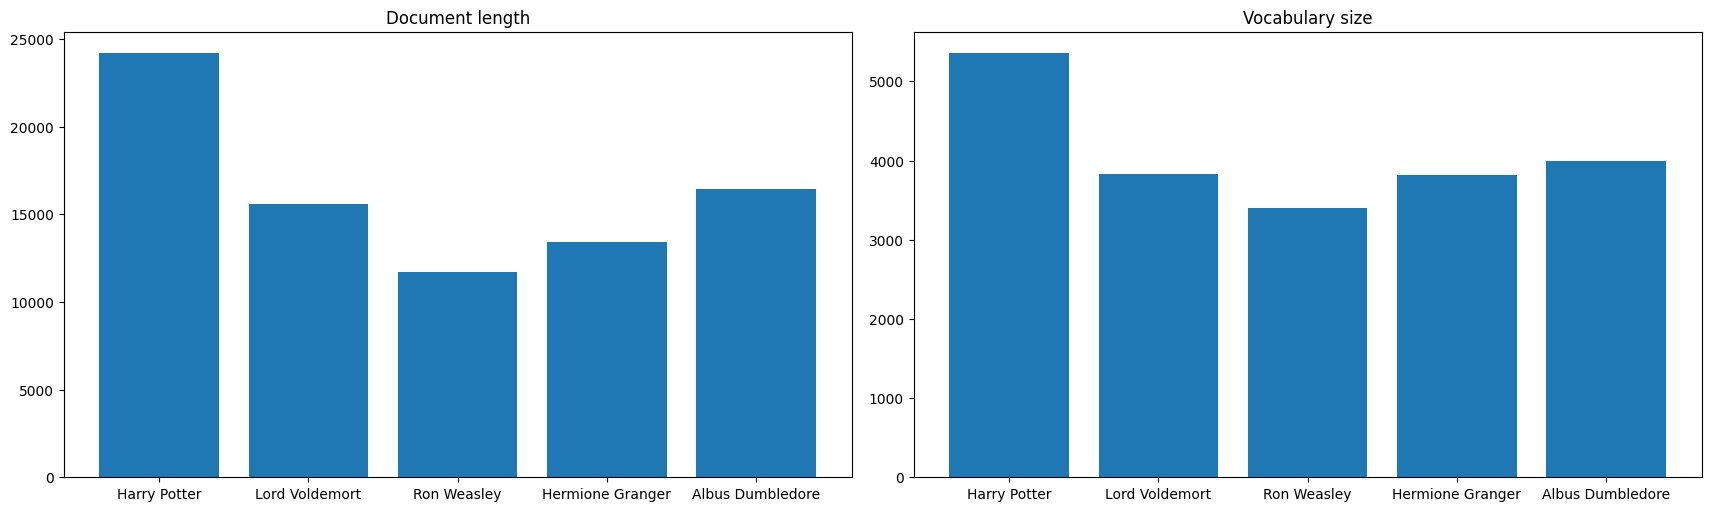

In [65]:
# Plot document length and vocabulary size by character
def plot_doc_length_vocab_size(documents: dict = character_tokens, characters: list = central_characters):
    doc_length = {char: len(doc) for char, doc in documents.items()}
    vocab_size = {char: len(set(doc)) for char, doc in documents.items()}

    fig, ax = plt.subplots(1, 2, figsize=(17, 5), constrained_layout=True)
    ax[0].bar(characters, [doc_length[char] for char in characters])
    ax[0].set_title('Document length')
    ax[1].bar(characters, [vocab_size[char] for char in characters])
    ax[1].set_title('Vocabulary size')
    plt.show()

plot_doc_length_vocab_size()

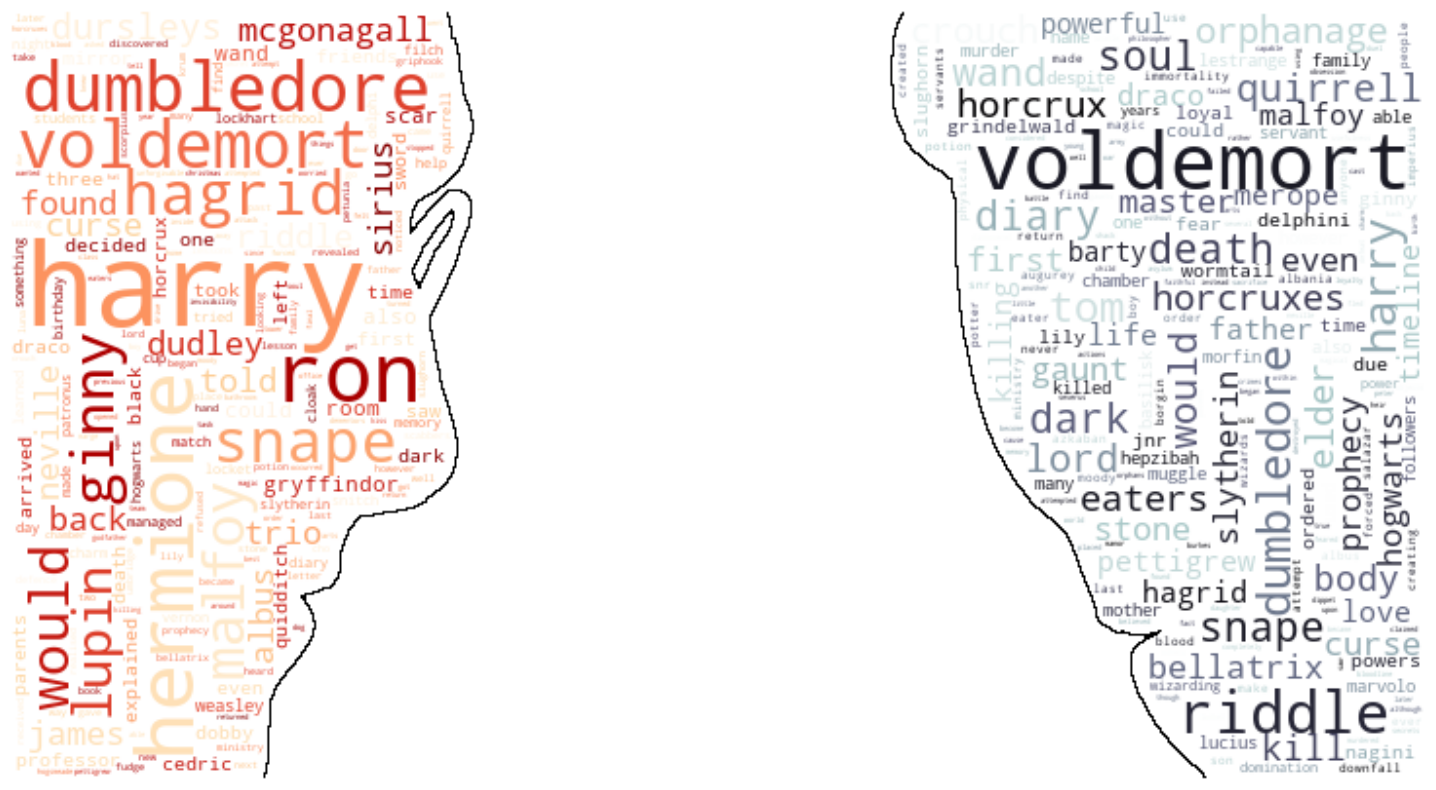

In [111]:
# plot the wordclouds for each central character
colormaps = {'Harry Potter': 'OrRd', 'Lord Voldemort': 'bone'}

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs_dict = {'Harry Potter': axs[0], 'Lord Voldemort': axs[1]}

for character, image in zip(central_characters[:2], os.listdir('3.Text_files/WordCloud_style/')):
    mask = np.array(Image.open(f"3.Text_files/WordCloud_style/{image}"))

    mask1 = np.where(mask==0, 255, mask)
    wordcloud = WordCloud(background_color="white",
                            mask=mask1,
                            contour_color='black',
                            contour_width=1,
                            colormap=colormaps[character]).generate_from_frequencies(calc_tf_idf(character=character))
    axs_dict[character].imshow(wordcloud, interpolation='bilinear')

    axs_dict[character].axis("off")
plt.savefig(f'3.Text_files/WordCloud_output/first_wordcloud.png', dpi='figure', bbox_inches='tight')
plt.show()